# Ищем мусор на побережье Камчатки по фоткам с дрона

Мы обучили бейзлайн-модель для поиска и сегментации мусора. Она была обучена на смеси датасета, который предоставлен вам как обучающий и на наших дополнительных данных.
Этот пример предназначен только для того, чтобы продемонстрировать как собрать данные для отправки, вы не обязаны использовать архитектуру/фреймворк/whatsoever. Более того, так как у вас нет наших весов и части функций, этот пример невозможно будет просто взять и завести на вашей машине, модель придется менять.

### Импорты, функции

In [ ]:
import torch, torchvision

In [ ]:
!pip install detectron2

ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


In [ ]:
# import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

ModuleNotFoundError: ignored

In [ ]:
import numpy as np
import os, json, cv2, random, yaml

In [ ]:
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode

In [ ]:
from detectron_train import setup

In [ ]:
from skimage.io import imread

In [ ]:
def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        ran = C if isinstance(C, list) else range(C)
        for i in ran:
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [np.mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)

def get_iou(preds, labels, label_to_calculate=None):
    C = preds.shape[1]
    preds = torch.argmax(preds, 1)
    if label_to_calculate is not None:
        return iou(preds, labels[:, 0], [label_to_calculate,]).mean()
    else:
        return iou(preds, labels[:, 0], C)[1:].mean() # ignoiring background label.

### Конфигурируем модель и параметры датасета

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml"))
with open('detectron_hydra_config.yaml') as f:
    hcfg = yaml.safe_load(f)
cfg = setup(hcfg['path_to_subconfig'], hcfg['zoo_checkpoint'])

In [ ]:
MetadataCatalog.get("waste").set(thing_classes=['metall', 'net', 'plastic', 'wood'])
waste_metadata = MetadataCatalog.get("waste")

Критично важная функция для отправки своих результатов: Run Length Encoding масок.

In [ ]:
def rle(inarray):
    """ run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) """
    ia = np.asarray(inarray)                # force numpy
    n = len(ia)
    if n == 0: 
        return (None, None, None)
    else:
        y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions
        return(z, p, ia[i])

def rlencode_mask(mask):
    l,s,v = rle(mask.flatten()) # length, starts, values
    l,s = l[v], s[v]
    encoded = ' '.join([' '.join(map(str, e)) for e in zip(s, l)])
    if not encoded:
        encoded = '0 0'
    return encoded

### Грузим веса, инициализируем инференс-класс

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join('/mnt/data/machine-learning/logs/waste/2021-10-07_18-09-49/output', "model_final.pth")  # path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join('/mnt/data/machine-learning/logs/waste/2021-10-17_00-23-07/output', "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/02 14:43:24 fvcore.common.checkpoint]: [Checkpointer] Loading from /mnt/data/machine-learning/logs/waste/2021-10-17_00-23-07/output/model_final.pth ...


### Просматриваем, тестируем и формируем посылку
Ниже три секции, которые делают следующее:
1. Просто визуализирует результаты
2. Визуализирует на два фрейма предсказанную и истинную маски для отладки, показывает IoU скор по классам. (Он не равен Dice но они тесно связаны).
3. Формирует csv файл посылки.

Критично важной для вас является только третья ячейка, остальные оставлены здесь, для возможности визуальной оценки работы предложенного бейзлайна.

/home/ws/tb0536/anaconda3/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


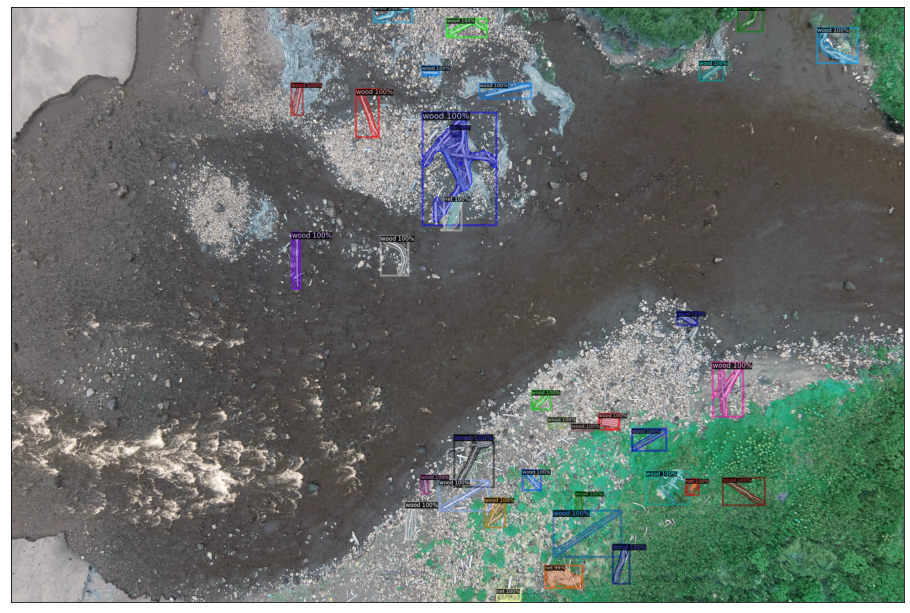

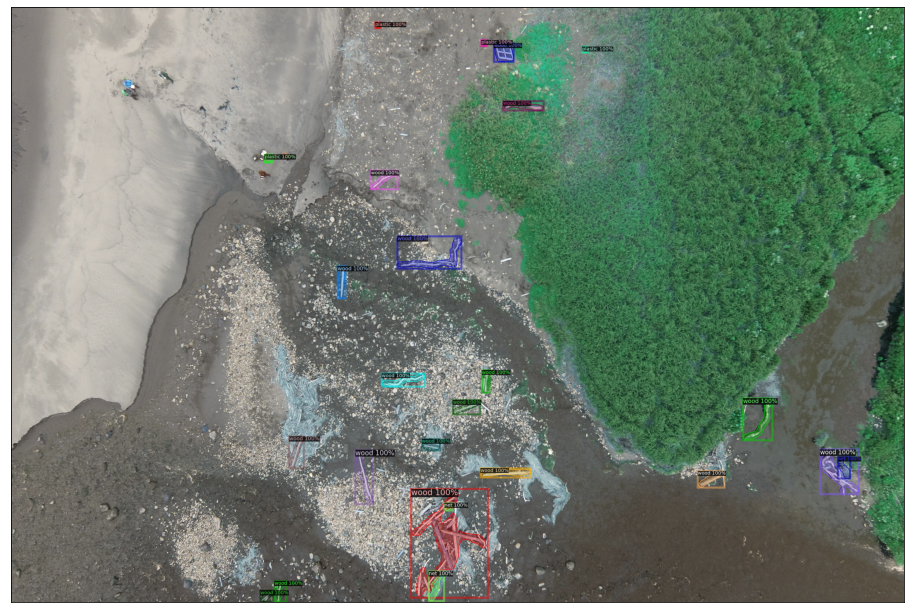

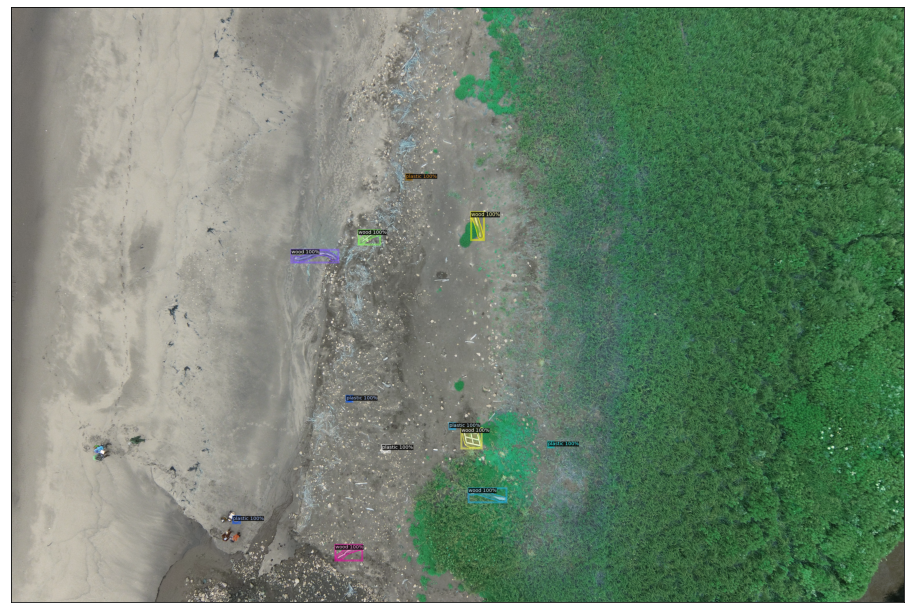

In [ ]:
for i in range(0, 3):
    im = cv2.imread(f'data/razmetka_1km/{i:02}_image.JPG') 
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1],
                   metadata=waste_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(16, 16))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

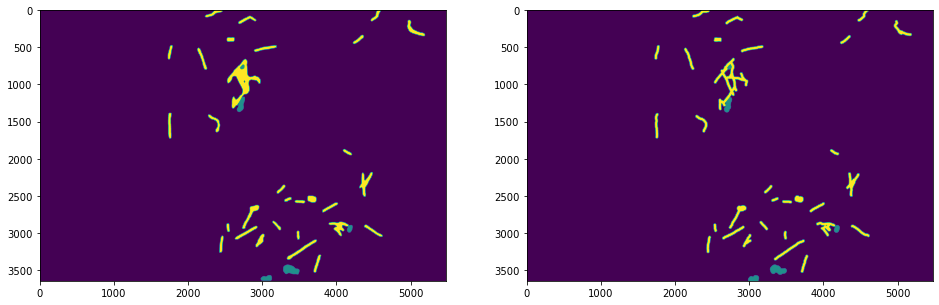

[100.          88.01845039 100.          80.11442441]


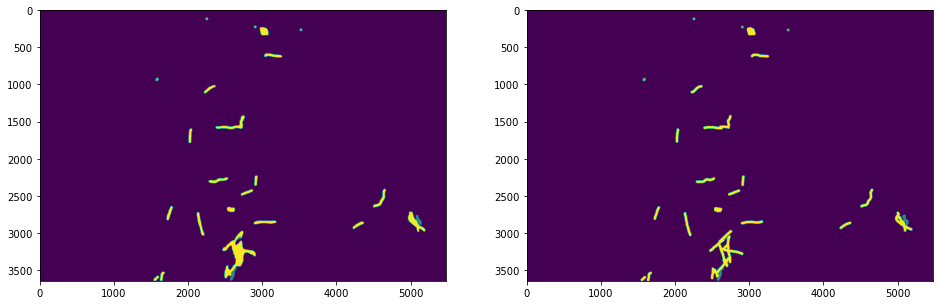

[100.          79.77005008  86.48542159  80.80302516]


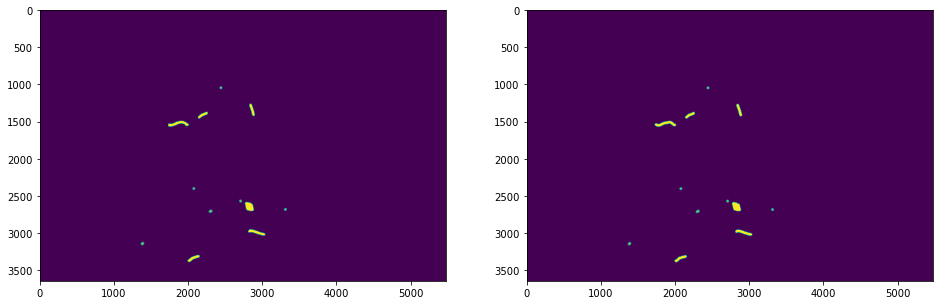

[100.         100.          86.94964408  89.31303825]


In [ ]:
for i in tqdm(range(0, 3)):
    im = cv2.imread(f'data/razmetka_1km/{i:02}_image.JPG') 
    outputs = predictor(im)
    
    predicted_mask = np.zeros(im.shape[:-1], np.uint8)
    for c, m in zip(outputs['instances'].pred_classes.detach().cpu().numpy(), 
                    outputs['instances'].pred_masks.detach().cpu().numpy()):
        predicted_mask[m] = c+1
    
    expected_mask = np.zeros(im.shape[:-1], np.uint8)
    for class_id, class_name in enumerate(waste_metadata.thing_classes, start=1):
        addr = f'data/razmetka_1km/{i:02}_{class_name}.png'
        if os.path.exists(addr):
            img = imread(addr)
            mask = (img.sum(-1) > 0)
            expected_mask[mask] = class_id
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,10))
    ax1.imshow(predicted_mask)
    ax2.imshow(expected_mask)
    plt.show()
    print(iou(predicted_mask, expected_mask, C=[1,2,3,4]))

In [ ]:
lines = ['Type_Id,Mask\n']
for i in tqdm(range(0, 31)):
    im = cv2.imread(f'data/razmetka_1km/{i:02}_image.JPG') 
    outputs = predictor(im)
    predicted_mask = np.zeros(im.shape[:-1], np.uint8)
    for c, m in zip(outputs['instances'].pred_classes.detach().cpu().numpy(), 
                    outputs['instances'].pred_masks.detach().cpu().numpy()):
        predicted_mask[m] = c+1
    for class_id, class_name in enumerate(waste_metadata.thing_classes, start=1):
        encoded = f'{class_name}_{i},' + rlencode_mask(predicted_mask == class_id) + f'\n'
        lines.append(encoded)

with open('baseline_solution.csv', 'w') as f:
    f.writelines(lines)

  0%|          | 0/31 [00:00<?, ?it/s]

Image positioning on an interactive map

In [ ]:
!pip install exif

In [ ]:
!pip install pillow

In [ ]:
import PIL
import exif
from exif import Image


def decimal_coords(coords, ref):
 decimal_degrees = coords[0] + coords[1] / 60 + coords[2] / 3600
 if ref == 'S' or ref == 'W':
     decimal_degrees = -decimal_degrees
 return decimal_degrees

In [ ]:
def image_coordinates(img_path):
    with open(img_path, 'rb') as src:
        img = Image(src)
    if img.has_exif:
        try:
            img.gps_longitude
            coords = (decimal_coords(img.gps_latitude,
                      img.gps_latitude_ref),
                      decimal_coords(img.gps_longitude,
                      img.gps_longitude_ref))
        except AttributeError:
            print('Не возможно получить координаты')    
    else:
        print('Не возможно получить координаты')    
    # print(f"Image {src.name}, OS Version:{img.get('software', 'Not Known')} ------")
    # print(f"Was taken: {img.datetime_original}, and has coordinates:{coords}")
    return img.datetime_original, coords

In [ ]:
imgtime,imgcoords =  image_coordinates('/content/DJI_0531.JPG')

In [ ]:
imgcoords

(51.43859722222222, 156.51635183333335)

In [ ]:
!pip install geopandas

In [ ]:
!pip install folium matplotlib mapclassify

In [ ]:
import folium

reservemap = folium.Map(location=[54.581650, 160.675355], zoom_start=5, width=900, height=600)
reservemap

In [ ]:
folium.Marker(location=[imgcoords[0], imgcoords[1]],popup= imgtime ,icon=folium.Icon(color="orange", icon="info-sign")).add_to(reservemap)
reservemap

In [90]:
import pickle

with open('/content/drive/MyDrive/kamchatka/number_obj.pickle', 'rb') as handle:
    fileToLevel= pickle.load(handle)

In [ ]:
fileToLevel

In [98]:
import os

folder = '/content/drive/MyDrive/kamchatka/4_речка_1км'

for filename in os.listdir(folder):
  curFile = folder+'/'+filename
  if fileToLevel[filename] == 0:
    imgtime,imgcoords =  image_coordinates(curFile)
    folium.Marker(location=[imgcoords[0], imgcoords[1]],popup= imgtime ,icon=folium.Icon(color="green", icon="info-sign")).add_to(reservemap)
  elif fileToLevel[filename]<20 and fileToLevel[filename] != 0:
    imgtime,imgcoords =  image_coordinates(curFile)
    folium.Marker(location=[imgcoords[0], imgcoords[1]],popup= imgtime ,icon=folium.Icon(color="yellow", icon="info-sign")).add_to(reservemap)
  elif fileToLevel[filename]>=20 and fileToLevel[filename]<=45:
    imgtime,imgcoords =  image_coordinates(curFile)
    folium.Marker(location=[imgcoords[0], imgcoords[1]],popup= imgtime ,icon=folium.Icon(color="orange", icon="info-sign")).add_to(reservemap)
  else:
    imgtime,imgcoords =  image_coordinates(curFile)
    folium.Marker(location=[imgcoords[0], imgcoords[1]],popup= imgtime ,icon=folium.Icon(color="red", icon="info-sign")).add_to(reservemap)

reservemap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
